# DEAM Dataset - Feed Forward Neural Network
## Essentia Best All & openSMILE ComParE2016 Featureset

## Import relevant libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torcheval.metrics import R2Score

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import math

import sys
sys.path.insert(1, '../../utils')
from paths import *

## Neural Network Training

### Import annotations dataset

In [2]:
df_annotations = pd.read_csv(get_deam_path('processed/annotations/deam_static_annotations.csv'))
df_annotations

,song_id,valence_mean_mapped,arousal_mean_mapped
0,2,-0.475,-0.500
1,3,-0.375,-0.425
2,4,0.175,0.125
3,5,-0.150,0.075
4,7,0.200,0.350
...,...,...,...
1739,1996,-0.275,0.225
1740,1997,0.075,-0.275
1741,1998,0.350,0.300
1742,1999,-0.100,0.100


### Import the featureset

This is where you should change between normalised and standardised, and untouched featuresets!

In [3]:
df_essentia_all_opensmile_compare2016_features = pd.read_csv(get_deam_path('processed/features/integrated/standardised_essentia_all_opensmile_compare2016_features.csv'))

# drop Unnamed:0 column
df_essentia_all_opensmile_compare2016_features = df_essentia_all_opensmile_compare2016_features[df_essentia_all_opensmile_compare2016_features.columns[1:]]

df_essentia_all_opensmile_compare2016_features

,song_id,lowlevel.average_loudness,lowlevel.barkbands_crest.dmean,lowlevel.barkbands_crest.dmean2,lowlevel.barkbands_crest.dvar,lowlevel.barkbands_crest.dvar2,lowlevel.barkbands_crest.max,lowlevel.barkbands_crest.mean,lowlevel.barkbands_crest.median,lowlevel.barkbands_crest.min,...,mfcc_sma_de[14]_peakRangeAbs,mfcc_sma_de[14]_peakRangeRel,mfcc_sma_de[14]_peakMeanAbs,mfcc_sma_de[14]_peakMeanMeanDist,mfcc_sma_de[14]_peakMeanRel,mfcc_sma_de[14]_minRangeRel,mfcc_sma_de[14]_meanRisingSlope,mfcc_sma_de[14]_stddevRisingSlope,mfcc_sma_de[14]_meanFallingSlope,mfcc_sma_de[14]_stddevFallingSlope
0,2,0.568151,-0.495162,-0.392697,-0.744706,-0.546485,-0.870470,-0.239716,-0.144909,-0.751646,...,-0.631867,-0.365685,-0.279802,-0.282638,1.033912,1.253936,0.258343,-0.101681,0.267050,-0.103648
1,3,-1.189985,-1.329502,-1.219457,-0.832461,-0.787198,1.027719,1.839969,1.739902,0.983723,...,-0.952109,-1.043699,-0.949817,-0.947268,-0.967357,0.042120,-1.127785,-0.883942,-1.084239,-0.561874
2,4,0.650480,-0.120976,-0.098623,-0.270405,-0.093387,-1.198606,-0.493636,-0.348739,-0.673459,...,-0.252214,-0.788912,-0.139047,-0.140901,1.033912,0.889151,-0.026883,0.089203,-0.241184,-0.576476
3,5,0.304588,-0.253761,-0.268728,-0.555905,-0.502125,0.225857,-0.133929,-0.197590,0.271977,...,-0.484816,-1.100697,-0.386997,-0.392154,1.033909,0.387215,-0.513832,-0.330955,-0.729651,-0.400833
4,7,0.651505,-0.965369,-1.022563,-0.383251,-0.509374,-0.011622,1.571188,1.686327,-0.514739,...,-0.679149,0.063000,-1.232202,-1.229221,-0.967357,0.368769,-1.143719,-1.322279,-1.174207,-1.294879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739,1996,0.675713,1.006280,1.063360,0.713243,0.633269,-0.779093,-0.607815,-0.681665,-0.013183,...,-0.774443,0.503124,-0.529866,-0.535381,1.033905,-0.030763,-0.263638,-0.737909,0.002047,-0.727175
1740,1997,0.683125,-0.291635,-0.136966,-0.549051,-0.394859,-1.571368,-0.677912,-0.561040,-0.216045,...,-0.029122,-0.435924,-0.013004,-0.020709,1.033884,-0.033798,0.353010,0.525906,0.453648,0.424850
1741,1998,0.291013,0.225089,0.192632,-0.015061,-0.102338,-0.223639,-0.920913,-0.808273,-1.243963,...,-0.697061,1.159923,-0.806402,-0.809586,1.033912,-0.252968,-0.728777,-1.008194,-0.453289,-0.757926
1742,1999,0.577845,0.026765,0.244953,-0.602676,-0.436818,-1.339357,-0.815125,-0.667085,0.293630,...,-0.391407,1.480851,-0.725574,-0.727505,1.033912,-0.852857,-0.127534,-0.522571,-0.095621,-0.490813


In [4]:
df_essentia_all_opensmile_compare2016_features.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1744 entries, 0 to 1743
Data columns (total 10887 columns):
 #      Column                                                    Dtype  
---     ------                                                    -----  
 0      song_id                                                   int64  
 1      lowlevel.average_loudness                                 float64
 2      lowlevel.barkbands_crest.dmean                            float64
 3      lowlevel.barkbands_crest.dmean2                           float64
 4      lowlevel.barkbands_crest.dvar                             float64
 5      lowlevel.barkbands_crest.dvar2                            float64
 6      lowlevel.barkbands_crest.max                              float64
 7      lowlevel.barkbands_crest.mean                             float64
 8      lowlevel.barkbands_crest.median                           float64
 9      lowlevel.barkbands_crest.min                              float64
 1

Join both the featureset and annotation set together

In [5]:
df_essentia_all_opensmile_compare2016_whole = pd.merge(df_essentia_all_opensmile_compare2016_features, df_annotations, how='inner', on='song_id')
df_essentia_all_opensmile_compare2016_whole = df_essentia_all_opensmile_compare2016_whole.drop('song_id', axis=1)
df_essentia_all_opensmile_compare2016_whole

,lowlevel.average_loudness,lowlevel.barkbands_crest.dmean,lowlevel.barkbands_crest.dmean2,lowlevel.barkbands_crest.dvar,lowlevel.barkbands_crest.dvar2,lowlevel.barkbands_crest.max,lowlevel.barkbands_crest.mean,lowlevel.barkbands_crest.median,lowlevel.barkbands_crest.min,lowlevel.barkbands_crest.stdev,...,mfcc_sma_de[14]_peakMeanAbs,mfcc_sma_de[14]_peakMeanMeanDist,mfcc_sma_de[14]_peakMeanRel,mfcc_sma_de[14]_minRangeRel,mfcc_sma_de[14]_meanRisingSlope,mfcc_sma_de[14]_stddevRisingSlope,mfcc_sma_de[14]_meanFallingSlope,mfcc_sma_de[14]_stddevFallingSlope,valence_mean_mapped,arousal_mean_mapped
0,0.568151,-0.495162,-0.392697,-0.744706,-0.546485,-0.870470,-0.239716,-0.144909,-0.751646,-0.806035,...,-0.279802,-0.282638,1.033912,1.253936,0.258343,-0.101681,0.267050,-0.103648,-0.475,-0.500
1,-1.189985,-1.329502,-1.219457,-0.832461,-0.787198,1.027719,1.839969,1.739902,0.983723,0.411352,...,-0.949817,-0.947268,-0.967357,0.042120,-1.127785,-0.883942,-1.084239,-0.561874,-0.375,-0.425
2,0.650480,-0.120976,-0.098623,-0.270405,-0.093387,-1.198606,-0.493636,-0.348739,-0.673459,-0.913741,...,-0.139047,-0.140901,1.033912,0.889151,-0.026883,0.089203,-0.241184,-0.576476,0.175,0.125
3,0.304588,-0.253761,-0.268728,-0.555905,-0.502125,0.225857,-0.133929,-0.197590,0.271977,-0.239829,...,-0.386997,-0.392154,1.033909,0.387215,-0.513832,-0.330955,-0.729651,-0.400833,-0.150,0.075
4,0.651505,-0.965369,-1.022563,-0.383251,-0.509374,-0.011622,1.571188,1.686327,-0.514739,-0.630103,...,-1.232202,-1.229221,-0.967357,0.368769,-1.143719,-1.322279,-1.174207,-1.294879,0.200,0.350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739,0.675713,1.006280,1.063360,0.713243,0.633269,-0.779093,-0.607815,-0.681665,-0.013183,-0.518090,...,-0.529866,-0.535381,1.033905,-0.030763,-0.263638,-0.737909,0.002047,-0.727175,-0.275,0.225
1740,0.683125,-0.291635,-0.136966,-0.549051,-0.394859,-1.571368,-0.677912,-0.561040,-0.216045,-0.915896,...,-0.013004,-0.020709,1.033884,-0.033798,0.353010,0.525906,0.453648,0.424850,0.075,-0.275
1741,0.291013,0.225089,0.192632,-0.015061,-0.102338,-0.223639,-0.920913,-0.808273,-1.243963,-0.577341,...,-0.806402,-0.809586,1.033912,-0.252968,-0.728777,-1.008194,-0.453289,-0.757926,0.350,0.300
1742,0.577845,0.026765,0.244953,-0.602676,-0.436818,-1.339357,-0.815125,-0.667085,0.293630,-1.528391,...,-0.725574,-0.727505,1.033912,-0.852857,-0.127534,-0.522571,-0.095621,-0.490813,-0.100,0.100


#### Prepare dataframes for the neural network

Perform splitting of the dataframe into training and testing sets

In [6]:
features = df_essentia_all_opensmile_compare2016_features.drop('song_id', axis=1)
features

,lowlevel.average_loudness,lowlevel.barkbands_crest.dmean,lowlevel.barkbands_crest.dmean2,lowlevel.barkbands_crest.dvar,lowlevel.barkbands_crest.dvar2,lowlevel.barkbands_crest.max,lowlevel.barkbands_crest.mean,lowlevel.barkbands_crest.median,lowlevel.barkbands_crest.min,lowlevel.barkbands_crest.stdev,...,mfcc_sma_de[14]_peakRangeAbs,mfcc_sma_de[14]_peakRangeRel,mfcc_sma_de[14]_peakMeanAbs,mfcc_sma_de[14]_peakMeanMeanDist,mfcc_sma_de[14]_peakMeanRel,mfcc_sma_de[14]_minRangeRel,mfcc_sma_de[14]_meanRisingSlope,mfcc_sma_de[14]_stddevRisingSlope,mfcc_sma_de[14]_meanFallingSlope,mfcc_sma_de[14]_stddevFallingSlope
0,0.568151,-0.495162,-0.392697,-0.744706,-0.546485,-0.870470,-0.239716,-0.144909,-0.751646,-0.806035,...,-0.631867,-0.365685,-0.279802,-0.282638,1.033912,1.253936,0.258343,-0.101681,0.267050,-0.103648
1,-1.189985,-1.329502,-1.219457,-0.832461,-0.787198,1.027719,1.839969,1.739902,0.983723,0.411352,...,-0.952109,-1.043699,-0.949817,-0.947268,-0.967357,0.042120,-1.127785,-0.883942,-1.084239,-0.561874
2,0.650480,-0.120976,-0.098623,-0.270405,-0.093387,-1.198606,-0.493636,-0.348739,-0.673459,-0.913741,...,-0.252214,-0.788912,-0.139047,-0.140901,1.033912,0.889151,-0.026883,0.089203,-0.241184,-0.576476
3,0.304588,-0.253761,-0.268728,-0.555905,-0.502125,0.225857,-0.133929,-0.197590,0.271977,-0.239829,...,-0.484816,-1.100697,-0.386997,-0.392154,1.033909,0.387215,-0.513832,-0.330955,-0.729651,-0.400833
4,0.651505,-0.965369,-1.022563,-0.383251,-0.509374,-0.011622,1.571188,1.686327,-0.514739,-0.630103,...,-0.679149,0.063000,-1.232202,-1.229221,-0.967357,0.368769,-1.143719,-1.322279,-1.174207,-1.294879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739,0.675713,1.006280,1.063360,0.713243,0.633269,-0.779093,-0.607815,-0.681665,-0.013183,-0.518090,...,-0.774443,0.503124,-0.529866,-0.535381,1.033905,-0.030763,-0.263638,-0.737909,0.002047,-0.727175
1740,0.683125,-0.291635,-0.136966,-0.549051,-0.394859,-1.571368,-0.677912,-0.561040,-0.216045,-0.915896,...,-0.029122,-0.435924,-0.013004,-0.020709,1.033884,-0.033798,0.353010,0.525906,0.453648,0.424850
1741,0.291013,0.225089,0.192632,-0.015061,-0.102338,-0.223639,-0.920913,-0.808273,-1.243963,-0.577341,...,-0.697061,1.159923,-0.806402,-0.809586,1.033912,-0.252968,-0.728777,-1.008194,-0.453289,-0.757926
1742,0.577845,0.026765,0.244953,-0.602676,-0.436818,-1.339357,-0.815125,-0.667085,0.293630,-1.528391,...,-0.391407,1.480851,-0.725574,-0.727505,1.033912,-0.852857,-0.127534,-0.522571,-0.095621,-0.490813


In [7]:
targets = df_annotations.drop('song_id', axis=1)
targets

,valence_mean_mapped,arousal_mean_mapped
0,-0.475,-0.500
1,-0.375,-0.425
2,0.175,0.125
3,-0.150,0.075
4,0.200,0.350
...,...,...
1739,-0.275,0.225
1740,0.075,-0.275
1741,0.350,0.300
1742,-0.100,0.100


Perform 80-20 train-test split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)

Create tensors for X_train and X_test

In [9]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float64)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float64)

Create tensors for Y_train and Y_test

In [10]:
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float64)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float64)

Define neural network parameters and instantitate neural network

In [11]:
input_size = 1
hidden_size = 20 
output_size = 2  # Output size for valence and arousal
learning_rate = 0.001
criterion = nn.MSELoss()

In [29]:
num_epochs = 295

Set a random seed to ensure consistent initial weights of the neural network

In [30]:
# Set the seed
seed = 42
torch.manual_seed(seed)

Define the neural network

In [31]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), 2)
        )

    def forward(self, x):
        return self.layers(x)

#### Training

Prepare input_train_data and target_train_labels

In [32]:
input_train_data = X_train_tensor.float()

# input_train_data = input_train_data.view(input_train_data.shape[1], -1)
print(input_train_data.shape)

target_train_labels = y_train_tensor

torch.Size([1395, 10886])


Training loop

In [33]:
def train_model(num_epochs):
  model = NeuralNetwork(input_size=input_train_data.shape[1])
  optimiser = optim.Adam(model.parameters(), lr=learning_rate)
  
  for epoch in range(num_epochs):
    optimiser.zero_grad()
    
    # forward pass
    output = model(input_train_data)

    # calculate loss
    loss = torch.sqrt(criterion(output.float(), target_train_labels.float()))

    # backward pass
    loss.backward()
    # update weights
    optimiser.step()

    print(f'Epoch {epoch + 1}, Loss: {math.sqrt(loss.item())}')

  print("Training completed.")
  return model

In [34]:
model = train_model(num_epochs)

Epoch 1, Loss: 0.5591092432054614
Epoch 2, Loss: 0.556747934806087
Epoch 3, Loss: 0.5553947560404504
Epoch 4, Loss: 0.5531729855170286
Epoch 5, Loss: 0.5461277897912609
Epoch 6, Loss: 0.5293027025866199
Epoch 7, Loss: 0.5141760089165679
Epoch 8, Loss: 0.5038825924073507
Epoch 9, Loss: 0.49676070848181614
Epoch 10, Loss: 0.48562595892655636
Epoch 11, Loss: 0.4758999236483752
Epoch 12, Loss: 0.4588361784937661
Epoch 13, Loss: 0.4538487540777339
Epoch 14, Loss: 0.444963016901992
Epoch 15, Loss: 0.4404338320518079
Epoch 16, Loss: 0.43733259813074404
Epoch 17, Loss: 0.4307571275977065
Epoch 18, Loss: 0.42966880757681614
Epoch 19, Loss: 0.42824936264778984
Epoch 20, Loss: 0.4204878430690039
Epoch 21, Loss: 0.4164382686078317
Epoch 22, Loss: 0.414636178538461
Epoch 23, Loss: 0.4121920968147178
Epoch 24, Loss: 0.4109018905063735
Epoch 25, Loss: 0.4064436597666759
Epoch 26, Loss: 0.4053294315492805
Epoch 27, Loss: 0.4015568009205892
Epoch 28, Loss: 0.39467495482283754
Epoch 29, Loss: 0.39325839

## Neural Network Testing

Prepare input_test_data and target_test_labels

In [35]:
input_test_data = X_test_tensor.float()

# input_test_data = input_test_data.view(input_test_data.shape[1], -1)
print(input_test_data.shape)

target_test_labels = y_test_tensor

torch.Size([349, 10886])


Generating scores

In [36]:
def test_model(trained_model):
  with torch.no_grad():
    test_pred = trained_model(input_test_data)
    test_loss = criterion(test_pred.float(), target_test_labels)

  rmse = math.sqrt(test_loss.item())
  print(f'Test RMSE: {rmse}')

  metric = R2Score()
  metric.update(test_pred, target_test_labels)
  r2_score = metric.compute().item()
  print(f'Test R^2 score: {r2_score}')
  return test_pred, rmse, r2_score

In [37]:
test_pred, rmse, r2_score = test_model(model)

Test RMSE: 0.1901079645206571
Test R^2 score: 0.6041976363867554


True values (test set)

In [38]:
target_test_labels

tensor([[-0.1500, -0.1500],
        [-0.3000, -0.1000],
        [ 0.2000,  0.3500],
        [ 0.2250,  0.4500],
        [-0.1750, -0.2000],
        [-0.5250, -0.3000],
        [-0.2500, -0.7750],
        [ 0.3000,  0.3000],
        [-0.1750, -0.4000],
        [ 0.4500,  0.1500],
        [ 0.1750,  0.0250],
        [-0.1750, -0.0250],
        [-0.0500, -0.3000],
        [ 0.1250,  0.3000],
        [-0.0750, -0.1500],
        [-0.2000, -0.2750],
        [-0.6000, -0.2250],
        [ 0.1500, -0.2000],
        [ 0.2750,  0.6000],
        [-0.1500, -0.4500],
        [-0.2250, -0.6250],
        [-0.0250, -0.4500],
        [-0.5250, -0.1250],
        [ 0.0000,  0.3250],
        [ 0.1250,  0.3750],
        [ 0.1500, -0.2500],
        [ 0.4500,  0.3250],
        [ 0.2500,  0.2250],
        [-0.1000,  0.0750],
        [ 0.4250,  0.1250],
        [-0.4500, -0.3500],
        [-0.0500,  0.3750],
        [-0.4750, -0.2000],
        [-0.2750, -0.4000],
        [-0.4000, -0.2250],
        [ 0.1000, -0

Predicted values

In [22]:
test_pred

tensor([[ 2.6309e-01,  1.9951e-01],
        [-2.1970e-01, -2.0872e-01],
        [ 4.8506e-01,  3.5939e-01],
        [ 1.7296e-01,  3.0748e-01],
        [-2.8166e-02, -2.5311e-01],
        [-2.4114e-01, -1.8044e-01],
        [-2.0348e-01, -5.4612e-01],
        [ 2.9151e-01,  2.8526e-01],
        [-3.0542e-01, -3.4420e-01],
        [ 4.7138e-01,  3.7295e-01],
        [ 1.9204e-01,  6.1049e-02],
        [-3.1726e-01, -4.0336e-02],
        [ 1.2534e-01, -3.1446e-01],
        [ 1.1536e-01,  2.1465e-01],
        [ 2.1314e-02,  8.0016e-02],
        [-2.1384e-01, -3.6538e-01],
        [-4.1105e-01, -2.1074e-01],
        [-1.9683e-02, -2.4322e-01],
        [ 1.6031e-01,  2.2719e-01],
        [ 8.2738e-03, -3.6479e-01],
        [-4.1241e-01, -4.8001e-01],
        [-3.9299e-01, -4.1314e-01],
        [-6.5385e-01, -4.7584e-01],
        [ 1.3860e-01,  3.4499e-01],
        [-1.0112e-01,  2.6650e-01],
        [ 2.9916e-01,  5.9959e-03],
        [ 3.7268e-01,  3.2737e-01],
        [ 2.4276e-01,  6.628

## Analyse relationship between epochs and r^2 score

Create lists to store the epochs and R^2 scores

In [23]:
num_epochs_list = [i for i in range(1, 301)]
r2_scores_list = []
rmse_list = []

Conduct training and testing for each num_epochs

In [24]:
for num_epochs in num_epochs_list:
  # Set the seed
  torch.manual_seed(seed)

  print(f'Num of epochs: {num_epochs}')
  
  model = train_model(num_epochs)

  print("Training completed.")
  print("Testing model...")

  test_pred, rmse, r2_score = test_model(model)
  r2_scores_list.append(r2_score)
  rmse_list.append(rmse)

print("Completed.")

Num of epochs: 1
Epoch 1, Loss: 0.5591092432054614
Training completed.
Training completed.
Testing model...
Test RMSE: 0.3054174928381013
Test R^2 score: -0.01795907717999201
Num of epochs: 2
Epoch 1, Loss: 0.5591092432054614
Epoch 2, Loss: 0.556747934806087
Training completed.
Training completed.
Testing model...
Test RMSE: 0.3026913410209616
Test R^2 score: 0.0009826572499452846
Num of epochs: 3
Epoch 1, Loss: 0.5591092432054614
Epoch 2, Loss: 0.556747934806087
Epoch 3, Loss: 0.5553947560404504
Training completed.
Training completed.
Testing model...
Test RMSE: 0.29946111593419067
Test R^2 score: 0.022222557530241438
Num of epochs: 4
Epoch 1, Loss: 0.5591092432054614
Epoch 2, Loss: 0.556747934806087
Epoch 3, Loss: 0.5553947560404504
Epoch 4, Loss: 0.5531729855170286
Training completed.
Training completed.
Testing model...
Test RMSE: 0.29145238417079067
Test R^2 score: 0.07348564593468482
Num of epochs: 5
Epoch 1, Loss: 0.5591092432054614
Epoch 2, Loss: 0.556747934806087
Epoch 3, Loss

### Plot the graph to visualise the relationship between epochs and r^2 score

Import relevant libraries

In [25]:
import matplotlib.pyplot as plt

In [26]:
r2_scores_list

[-0.01795907717999201,
 0.0009826572499452846,
 0.022222557530241438,
 0.07348564593468482,
 0.18513512377689395,
 0.29818002896172147,
 0.33659685945433515,
 0.34254330186957327,
 0.38841091222681656,
 0.43269003990275234,
 0.4773945345719561,
 0.4712338552911093,
 0.5029735310920795,
 0.5234835786523115,
 0.5100226222589876,
 0.528677968428771,
 0.5303054595375076,
 0.5211320341407985,
 0.5437895632234945,
 0.5438295466309297,
 0.5292233147069593,
 0.5238976937387866,
 0.5168590895351195,
 0.5430521678475632,
 0.5334535203156976,
 0.5567480936667555,
 0.5612590254317467,
 0.5579230061134364,
 0.5662449361066997,
 0.5456337946031898,
 0.5550611124032823,
 0.551415419039558,
 0.552432239931835,
 0.5428461952826764,
 0.5545179102122633,
 0.5046392131218661,
 0.5620406208650908,
 0.5566449309690858,
 0.5659691754880933,
 0.545929690039673,
 0.5671267575132093,
 0.5570708064982662,
 0.5494106312882684,
 0.5604194568135048,
 0.5708337457321662,
 0.566018768116191,
 0.5474547054521641,
 0.5

Plot the line graph

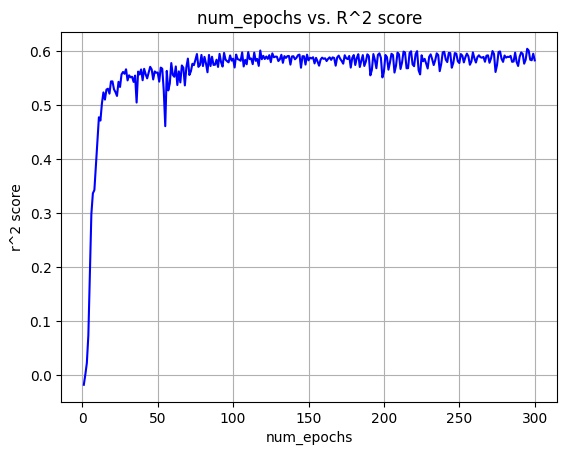

In [27]:
plt.plot(num_epochs_list, r2_scores_list, color='b', linestyle='-')
plt.title('num_epochs vs. R^2 score')
plt.xlabel('num_epochs')
plt.ylabel('r^2 score') 
plt.grid(True)
plt.show() 

In [28]:
max_r2_score = max(r2_scores_list)
corresponding_rmse = rmse_list[r2_scores_list.index(max_r2_score)]
corresponding_num_epochs = num_epochs_list[r2_scores_list.index(max_r2_score)]

print(f'Max R^2 score: {max_r2_score}')
print(f'Corresponding RMSE: {corresponding_rmse}')
print(f'Corresponding num_epochs: {corresponding_num_epochs}')

Max R^2 score: 0.6041976363867554
Corresponding RMSE: 0.1901079645206571
Corresponding num_epochs: 295
